In [1]:
import tensorflow as tf
import math
import numpy as np
from matplotlib import pyplot as plt
from mnist import MNIST
from utils import show_image
from sklearn import metrics

# 1 . Load MNIST dataset

In [2]:
mnist = MNIST('datasets/mnist')
train_images, train_labels = mnist.load_training()
test_images, test_labels = mnist.load_testing()

shape = (28,28)

Print some images from dataset

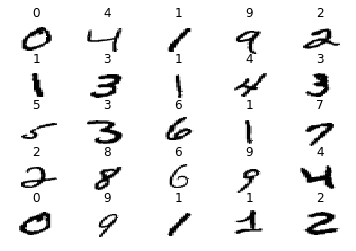

In [3]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(1,26):
    ax = fig.add_subplot(5, 5, i)
    ax.set_title(train_labels[i])
    show_image(train_images[i],shape, ax=ax)

# 2. Build a simple NN

## 2.1 - Set a dict that saves the variables to training

In [23]:
input_size = shape[0]*shape[1]

l1_size = 200
l2_size = 100
l3_size = 50
l4_size = 25

output_size = 10

w = {
    'w1':tf.Variable(tf.random_normal([input_size, l1_size])),
    'w2':tf.Variable(tf.random_normal([l1_size, l2_size])),
    'w3':tf.Variable(tf.random_normal([l2_size, l3_size])),
    'w4':tf.Variable(tf.random_normal([l3_size, l4_size])),
    'w5':tf.Variable(tf.random_normal([l4_size, output_size])),

}

b = {
    'b1': tf.Variable(tf.random_normal([l1_size])),
    'b2': tf.Variable(tf.random_normal([l2_size])),
    'b3': tf.Variable(tf.random_normal([l3_size])),
    'b4': tf.Variable(tf.random_normal([l4_size])),
    'b5': tf.Variable(tf.random_normal([output_size])),
}

## 2.2 - Build the Neural Network
 Activation function in hidden layers: ReLu
 Activation function in output layer: Sigmoid

In [44]:
def nn(x_value):
    
    h1 = tf.nn.relu(tf.add(tf.matmul(x_value,w['w1']),b['b1']))
    h2 = tf.nn.relu(tf.add(tf.matmul(h1,w['w2']),b['b2']))
    h3 = tf.nn.relu(tf.add(tf.matmul(h2,w['w3']),b['b3']))
    h4 = tf.nn.relu(tf.add(tf.matmul(h3,w['w4']),b['b4']))

    out = tf.nn.sigmoid(tf.add(tf.matmul(h4,w['w5']),b['b5']))
    return out

### Run the Neural Network without training

In [45]:
init_op = tf.global_variables_initializer()

x_v = np.matrix(train_images[:2], dtype=np.float32)
with tf.Session() as sess:
    sess.run(init_op)
    out = nn(x_v)
    print(sess.run(out))

[[0. 0. 0. 0. 1. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 1. 0.]]


## 2.3 - LossFunction: Mean Square error

In [46]:
np_train_labels = np.zeros((len(train_labels),10), dtype=np.float32)
for i in range(len(train_labels)):
    np_train_labels[i,train_labels[i]]=1
    
np_test_labels = np.zeros((len(test_labels),10), dtype=np.int)
for i in range(len(test_labels)):
    np_test_labels[i,test_labels[i]]=1
    
np_train_images = np.matrix(train_images,dtype=np.float)

## 2.4 - Learning: Minimizing the LossFunction

In [47]:
def get_batch_range(batch_i,batch_size,total_size):
    i = batch_size*batch_i
    f = i + batch_size
    if f > total_size:
        f = total_size
    return i,f

Format test_label to calculate the accuracy

In [57]:
n_batchs = 20

total_size = len(train_labels)
batch_size = int(total_size/n_batchs)


train_x = tf.placeholder(dtype=tf.float32,shape=(batch_size,input_size), name='train_x')
train_y = tf.placeholder(dtype=tf.float32,shape=(batch_size,10), name='train_y')

test_x = tf.constant(test_images,dtype=tf.float32, name='test_x')
test_y = tf.constant(np_test_labels,dtype=tf.int32, name='test_y')

predicted_train = nn(train_x)
predicted_test = tf.to_int32(nn(test_x))

loss_op = tf.losses.mean_squared_error(train_y,predicted_train)

adam = tf.train.AdamOptimizer(learning_rate=0.001)
adam_optimization = adam.minimize(
                loss_op,
                var_list = w.values()+b.values()
            )

init_op_g = tf.global_variables_initializer()
init_op_l = tf.local_variables_initializer()

In [59]:
loss_vector = []
acc_vector = []

acc_op = tf.contrib.metrics.accuracy(
    predicted_test,
    test_y
)

with tf.Session() as sess:

    sess.run(init_op_g)
    sess.run(init_op_l)

    
    for i in range(100):
        print("="*10 +" EPOCH "+str(i)+" "+"="*10)
        
        for j in range(n_batchs):
            
            inicio,fim = get_batch_range(
                j,
                batch_size,
                total_size
            )   

            
            sess.run(adam_optimization, feed_dict={train_x:train_images[inicio:fim], train_y:np_train_labels[inicio:fim]})
            
            l = sess.run(loss_op,
                         feed_dict={
                             train_x:train_images[inicio:fim],
                             train_y:np_train_labels[inicio:fim]})
            acc_value = sess.run(acc_op,
                                 feed_dict={
                                     test_x:test_images,
                                     test_y:np_test_labels})
            
            loss_vector.append(l)  
            acc_vector.append(acc_value)
    
        print("LOSS: %s"%(str(l)))
        print("ACC: %s"%(acc_value))


========== EPOCH 0 ==========
LOSS: 0.37736666
ACC: 0.62321
========== EPOCH 1 ==========
LOSS: 0.37476668
ACC: 0.62715
========== EPOCH 2 ==========
LOSS: 0.3711
ACC: 0.62968
========== EPOCH 3 ==========
LOSS: 0.35873333
ACC: 0.64328
========== EPOCH 4 ==========
LOSS: 0.356
ACC: 0.64599
========== EPOCH 5 ==========
LOSS: 0.35563335
ACC: 0.64651
========== EPOCH 6 ==========
LOSS: 0.35566667
ACC: 0.64656
========== EPOCH 7 ==========
LOSS: 0.34780002
ACC: 0.65435
========== EPOCH 8 ==========
LOSS: 0.34513333
ACC: 0.65912
========== EPOCH 9 ==========
LOSS: 0.33693334
ACC: 0.66568
========== EPOCH 10 ==========
LOSS: 0.3326
ACC: 0.6691
========== EPOCH 11 ==========
LOSS: 0.32963333
ACC: 0.67191
========== EPOCH 12 ==========
LOSS: 0.32803366
ACC: 0.67327
========== EPOCH 13 ==========
LOSS: 0.32836667
ACC: 0.67317
========== EPOCH 14 ==========
LOSS: 0.32840002
ACC: 0.67326
========== EPOCH 15 ==========
LOSS: 0.3285
ACC: 0.673
========== EPOCH 16 ==========
LOSS: 0.32863334
ACC: 0

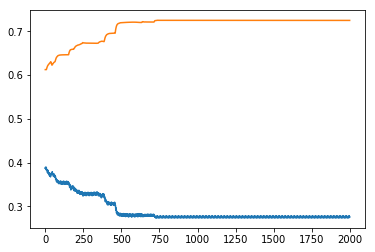

In [61]:
%matplotlib inline
plt.plot(loss_vector)
plt.plot(acc_vector)